In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from inspect import getmembers, isfunction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle, os
from sklearn.feature_selection import r_regression

%matplotlib inline


# Generate descriptors

## RDKit

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from inspect import getmembers, isfunction
import pandas as pd
import numpy as np

- get descriptor names and functions

In [28]:
acr2_list = []
desc_list = []
for n,f in getmembers(Descriptors, isfunction):
    if n.startswith('AUTOCORR2D'):
        acr2_list.append((n,f))
    elif n.startswith('_'):
        break
    else:
        desc_list.append((n,f))

desc_names = np.array([n for n,_ in desc_list])
acr2_names = np.array([n.replace('AUTOCORR2D','ACR2D') for n,_ in acr2_list])

- descriptor names

In [29]:
print(desc_names[:10])

['BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BCUT2D_MWHI' 'BCUT2D_MWLOW' 'BalabanJ'
 'BertzCT']


- Generate QM9 features

In [46]:
print(len(acr2_list), len(desc_list))

df = pd.read_csv('D:/DATA/polymers/QM9/qm9_origin.csv')
smiles = df.pop('smiles')

feat_desc = []
feat_acr2 = []
for smiles_str in tqdm(smiles.values, total=len(df.index)):
    m = Chem.MolFromSmiles(smiles_str)
    feat_desc.append([d(m) for _, d in desc_list])
    feat_acr2.append([d(m) for _, d in acr2_list])

192 122


100%|██████████| 133885/133885 [04:19<00:00, 515.92it/s]


 - Save features


In [30]:
mask = np.std(feat_desc, axis=0) == 0
if np.sum(mask) != 0:
    feat_desc = np.array(feat_desc)[:, ~mask]
    print(feat_desc.shape, 'removed {} features with zero STD: '.format(np.sum(mask)), desc_names[mask])
    desc_names = desc_names[~mask]

mask = np.std(feat_acr2, axis=0) == 0
if np.sum(mask) != 0:
    feat_acr2 = np.array(feat_acr2)[:, ~mask]
    print(feat_acr2.shape, 'removed {} features with zero STD: '.format(np.sum(mask)), acr2_names[mask])
    acr2_names = acr2_names[~mask]

df_target = df.copy()
df_feature = pd.DataFrame(np.concatenate([feat_desc, feat_acr2], axis=-1), columns=np.hstack([desc_names, acr2_names]))

df_target.to_csv('D:/DATA/polymers/QM9/target.csv', index=False)
df_feature.to_csv('D:/DATA/polymers/QM9/rdkit_feature.csv', index=False)

NameError: name 'feat_desc' is not defined

- load QM9 features

In [13]:
import pandas as pd
import pickle
df_feat = pd.read_csv('D:/DATA/polymers/QM9/rdkit_feature.csv')
df_tgt  = pd.read_csv('D:/DATA/polymers/QM9/target.csv')

In [3]:
df_feat.head()

,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BCUT2D_MWHI,BCUT2D_MWLOW,BalabanJ,BertzCT,...,ACR2D_90,ACR2D_91,ACR2D_92,ACR2D_93,ACR2D_94,ACR2D_95,ACR2D_96,ACR2D_97,ACR2D_98,ACR2D_99
0,-0.077558,-0.077558,0.144100,0.144100,2.503000,2.503000,12.011000,12.011000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.343926,-0.343926,-0.480600,-0.480600,2.134000,2.134000,14.007000,14.007000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.411510,-0.411510,-0.289300,-0.289300,0.823800,0.823800,15.999000,15.999000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.453806,-0.700895,0.579050,-0.575650,4.465350,3.310650,12.588350,11.433650,3.0,4.754888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.512628,-0.668432,0.585779,-0.568999,4.032459,1.580541,14.161969,11.856031,3.0,6.754888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0


In [4]:
df_tgt.head()

,dipole_moment,isotropic_polarizability,homo,lumo,band_gap,electronic_spatial_extent,zpve,heat_capacity,internal_energy_0K,internal_energy_298K,enthalpy_298K,free_energy_298K
0,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246


# Scikit-learn Recursive Feature Elimination test

## sklearn ensemble test

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [14]:
rseed = 100
regressors = {
    'LNR':LinearRegression(),
    'RFR':RandomForestRegressor(n_estimators=100, max_depth=10, random_state=rseed), 
    'GBR':GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=rseed),
    'ABR':AdaBoostRegressor(n_estimators=100, random_state=rseed),
    'ETR':ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=rseed),
}

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_feat, df_tgt, random_state=rseed, test_size=0.3)
features = x_train.columns
targets  = y_train.columns

In [19]:
rfe = RFE(regressors['LNR'], n_features_to_select=1)
rfe.fit(x_train[:1000], y_train.values[:1000,0])

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [24]:
y_train.shape

(93719, 12)

In [25]:
for name, regressor in regressors.items():
    output = {t:[] for t in targets}

    for _, y in tqdm(y_train.iteritems(), desc=name, total=len(y_train.columns)):
        rfe = RFE(regressor, n_features_to_select=1)
        rfe.fit(x_train[:1000], y[:1000])
        output[y.name] = [(int(i),f) for i,f in sorted(zip(rfe.ranking_, features), key=lambda x:x[0])]
        
    with open(f'D:/DATA/polymers/QM9/feature_importance/{name}_r100t0.3_1-1000.pickle','wb') as f:
        pickle.dump(output, f)

SVR:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
SVR:   0%|          | 0/12 [00:00<?, ?it/s]


ValueError: when `importance_getter=='auto'`, the underlying estimator SVR should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [28]:
for name, regressor in dict(XGB=XGBRegressor(random_state=rseed)).items():
    output = {t:[] for t in targets}
    for _, y in tqdm(y_train.iteritems(), desc=name, total=len(y_train.columns)):
        rfe = RFE(regressor, n_features_to_select=1)
        rfe.fit(x_train[:1000], y[:1000])
        output[y.name] = [(int(i),f) for i,f in sorted(zip(rfe.ranking_, features), key=lambda x:x[0])]
        
    with open(f'D:/DATA/polymers/QM9/feature_importance/{name}_r100t0.3_1-1000.pickle','wb') as f:
        pickle.dump(output, f)

XGB: 100%|██████████| 12/12 [08:36<00:00, 43.04s/it]


In [35]:
name = 'LNR'
regressor = regressors[name]
output = {t:[] for t in targets}
for _, y in tqdm(y_train.iteritems(), desc=name, total=len(y_train.columns)):
    rfe = RFE(regressor, n_features_to_select=1)
    rfe.fit(x_train, y)
    output[y.name] = [(int(i),f) for i,f in sorted(zip(rfe.ranking_, features), key=lambda x:x[0])]
    
with open(f'D:/DATA/polymers/QM9/feature_importance/{name}_r100t0.3_all.pickle','wb') as f:
    pickle.dump(output, f)

LNR: 100%|██████████| 12/12 [12:50<00:00, 64.23s/it]


In [5]:
name = 'LNR'
regressor = regressors[name]
output = {t:[] for t in targets}
for _, y in tqdm(y_train.iteritems(), desc=name, total=len(y_train.columns)):
    rfe = RFECV(regressor, n_jobs=5, cv=5, min_features_to_select=1)
    rfe.fit(x_train, y)
    output[y.name] = [(int(i),f) for i,f in sorted(zip(rfe.ranking_, features), key=lambda x:x[0])]
    
with open(f'D:/DATA/polymers/QM9/feature_importance/{name}_r100t0.3_all_CV5.pickle','wb') as f:
    pickle.dump(output, f)

LNR: 100%|██████████| 12/12 [34:03<00:00, 170.32s/it]


NameError: name 'pickle' is not defined

In [34]:
for k,v in dmp.items():
    print(k, len(v))

dipole_moment 307
isotropic_polarizability 307
homo 307
lumo 307
band_gap 307
electronic_spatial_extent 307
zpve 307
heat_capacity 307
internal_energy_0K 307
internal_energy_298K 307
enthalpy_298K 307
free_energy_298K 307


- 시간이 너무 오래 걸리는 문제가 있음. 
- 모델별로 따로 시행해야 함.
- 모델이 달라질 경우 정보가 쓸모 없어질 수 있음
- 다른 방법 필요함

## 모델별 테스트 결과

In [31]:
df_feat = pd.read_csv('D:/DATA/polymers/QM9/rdkit_feature.csv')
df_tgt  = pd.read_csv('D:/DATA/polymers/QM9/target.csv')

feature_names = df_feat.columns

In [32]:
def read_RFE_test_result(i, j):
    root = 'C:/Google Drive/CODES/f-polymer/rank_test'
    models = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    if len(models) <= i:
        return None
    model = models[i]
    props = os.listdir(os.path.join(root, model))
    if len(props) <= j:
        return None
    loss = np.loadtxt(os.path.join(root, model, props[j]))
    return loss, model, props[j]

def read_RFE_result(i):
    global feature_names
    root = 'D:/DATA/polymers/QM9/feature_importance'
    models = os.listdir(root)
    if len(models) <= i: return None
    model = models[i]
    with open(os.path.join(root, model), 'rb') as f:
        d = pickle.load(f)
    data = []
    props = []
    for prop, ranks in d.items():
        feats = [feat for rank, feat in ranks]
        data.append([feats.index(feat) for feat in feature_names])
        props.append(prop)
    return np.array(data), props, model

In [43]:
result = {}
for i in range(50):
    output = read_RFE_result(i)
    if output is None: break
    data, props, model = output
#    if 'CV5' in model: continue
    for rank, prop in zip(data, props):
        if prop not in result.keys(): result[prop] = {}
        result[prop][model.replace('.pickle','').replace('r100t0.3_','')] = rank

for prop, y in tqdm(df_tgt.iteritems(), total=df_tgt.shape[1]):
    pcc = np.abs([r_regression(x.values.reshape(-1,1), y.values)[0] for _, x in df_feat.iteritems()])
    pcc_rank = np.zeros_like(pcc)
    for rank, idx in enumerate(np.argsort(pcc)):
        pcc_rank[idx] = 306 - rank
    result[prop]['PCC'] = pcc_rank

100%|██████████| 12/12 [00:02<00:00,  4.53it/s]


In [74]:
pcc[:10], pcc_rank[:10]

(array([0.11816852, 0.10525824, 0.25363163, 0.09610099, 0.25931186,
        0.25288408, 0.56392254, 0.26723696, 0.22429552, 0.20688087]),
 array([192., 198., 126., 200., 125., 127.,  34., 119., 136., 141.]))

In [34]:
pcc[:10], pcc_rank[:10]

(array([0.11816852, 0.10525824, 0.25363163, 0.09610099, 0.25931186,
        0.25288408, 0.56392254, 0.26723696, 0.22429552, 0.20688087]),
 array([192., 198., 126., 200., 125., 127.,  34., 119., 136., 141.]))

In [44]:
result[prop].keys()

dict_keys(['ABR_1000', 'ETR_1000', 'GBR_1000', 'LNR_1000', 'LNR_all', 'LNR_all_CV5', 'RFR_1000', 'RFR_1000_CV5', 'XGB_1000', 'PCC'])

In [78]:
models = [
    ['XGB_1000', 'RFR_1000', 'GBR_1000', 'ETR_1000','ABR_1000', 'LNR_1000', 'PCC'],
    ['LNR_all_CV5', 'LNR_all', 'LNR_1000'],
    ['RFR_1000_CV5', 'LNR_all_CV5', 'RFR_1000', 'LNR_all'],
]

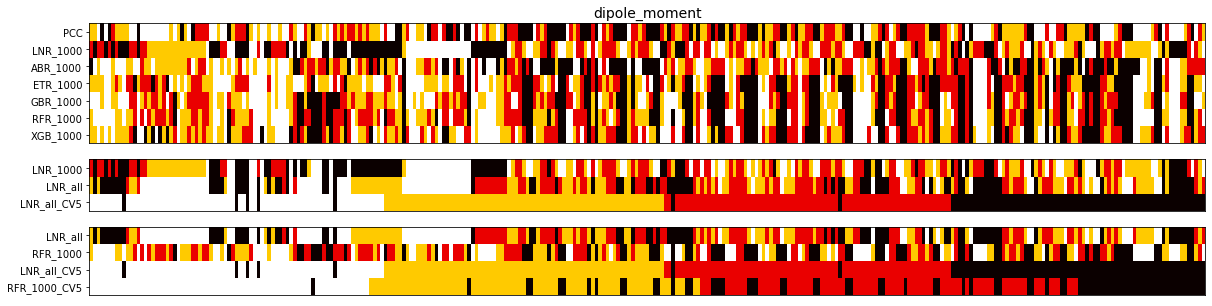

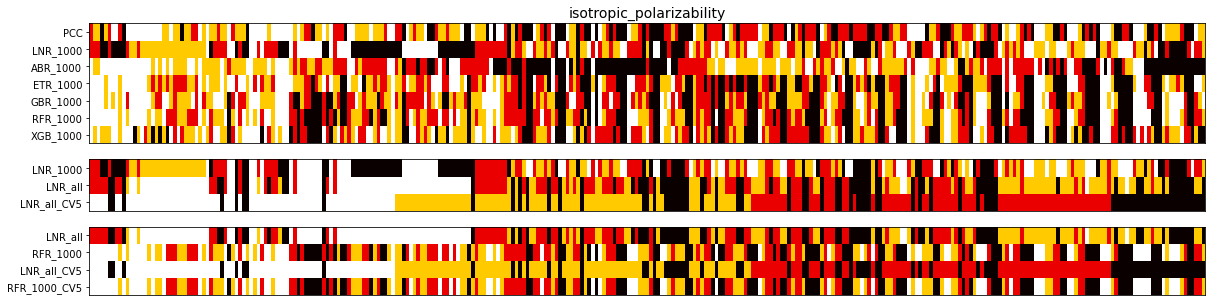

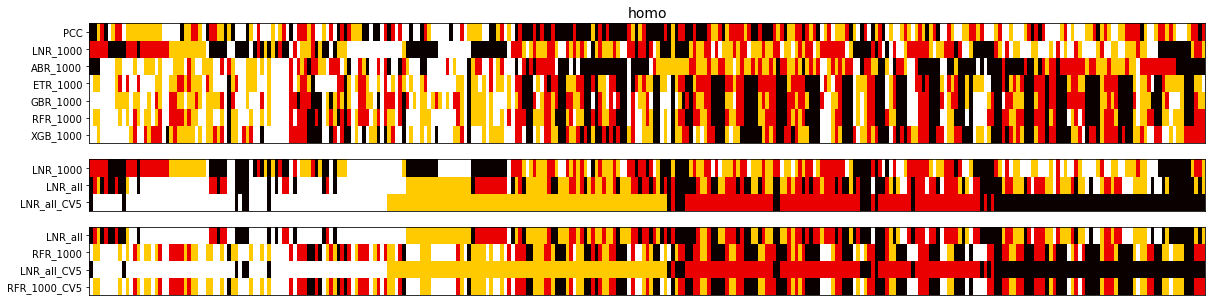

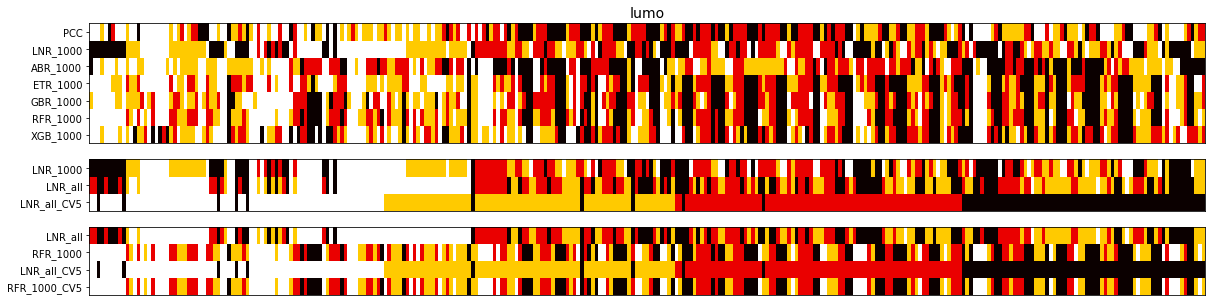

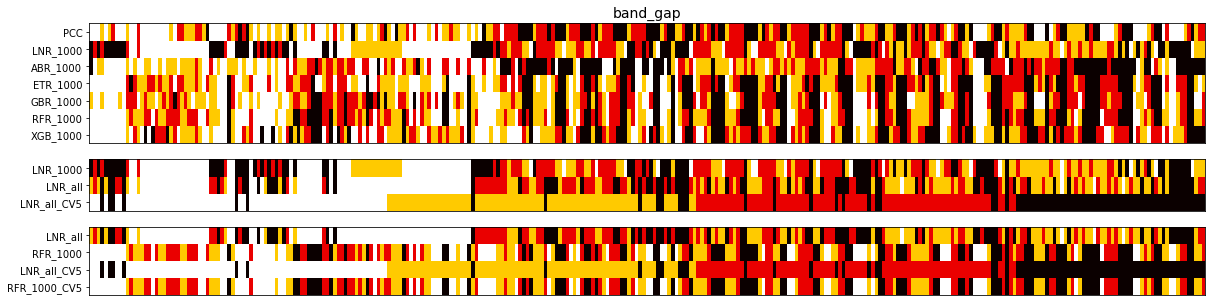

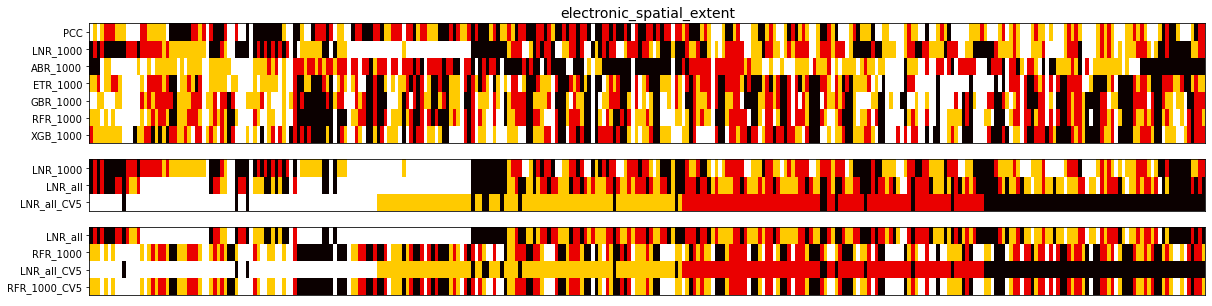

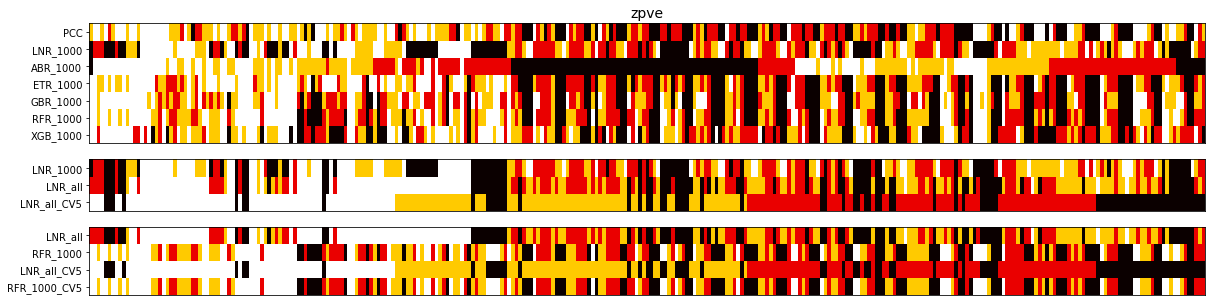

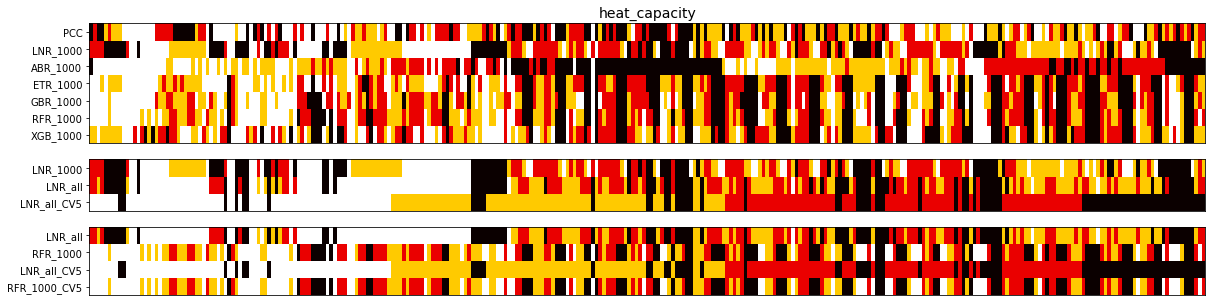

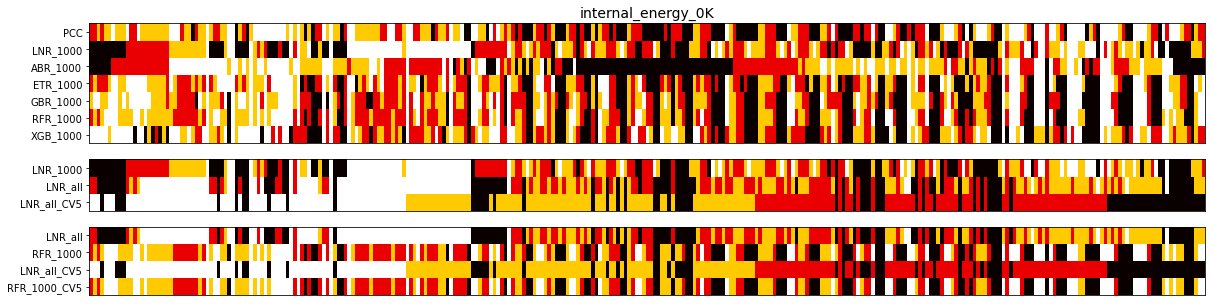

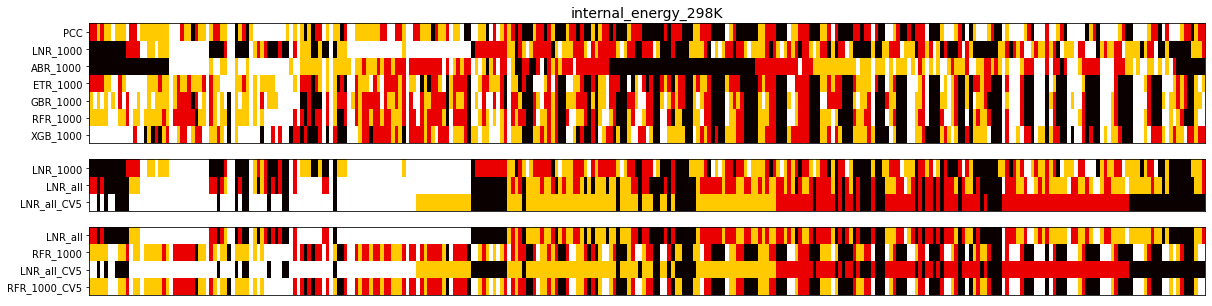

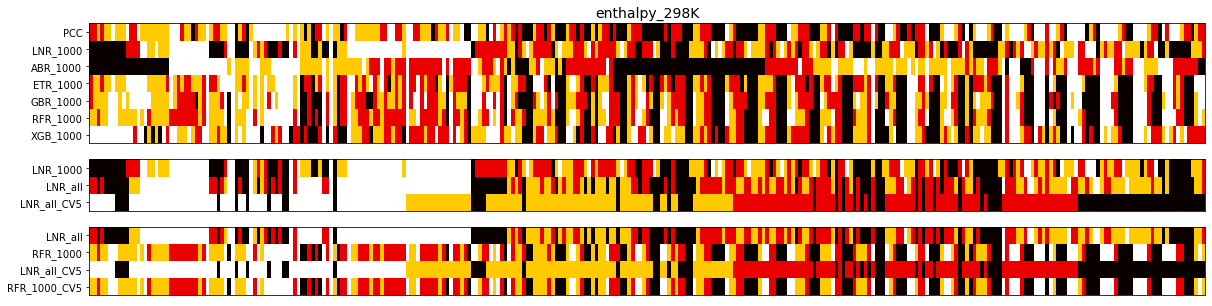

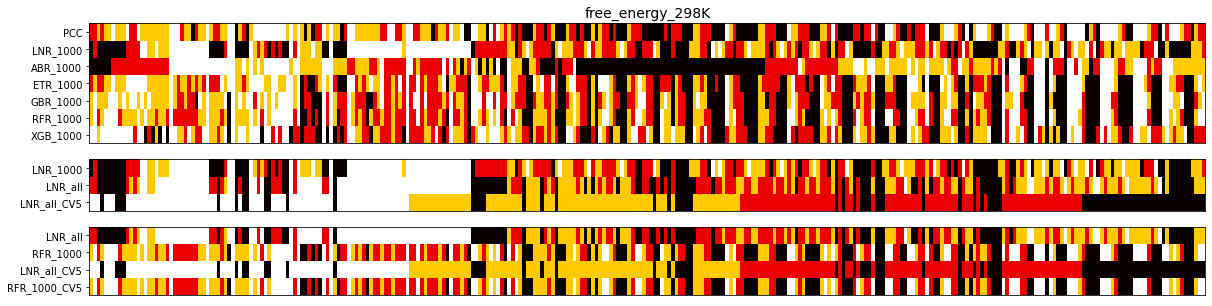

In [82]:
bins = 4
for prop, output in result.items():
    f, axs = plt.subplots(3, 1, figsize=(20, 5), gridspec_kw={'height_ratios':[len(m) for m in models]})
    axs[0].set_title(prop, fontsize=14)
    for ax, model in zip(axs, models):
        r = np.array((306 - np.vstack([output[m] for m in model]))*bins/307, dtype=int)
        ax.pcolormesh(r, cmap='hot')
        ytick = np.linspace(0.5, len(model)-0.5, len(model))
        ax.set_yticks(ytick, model)
        ax.set_xticks([])

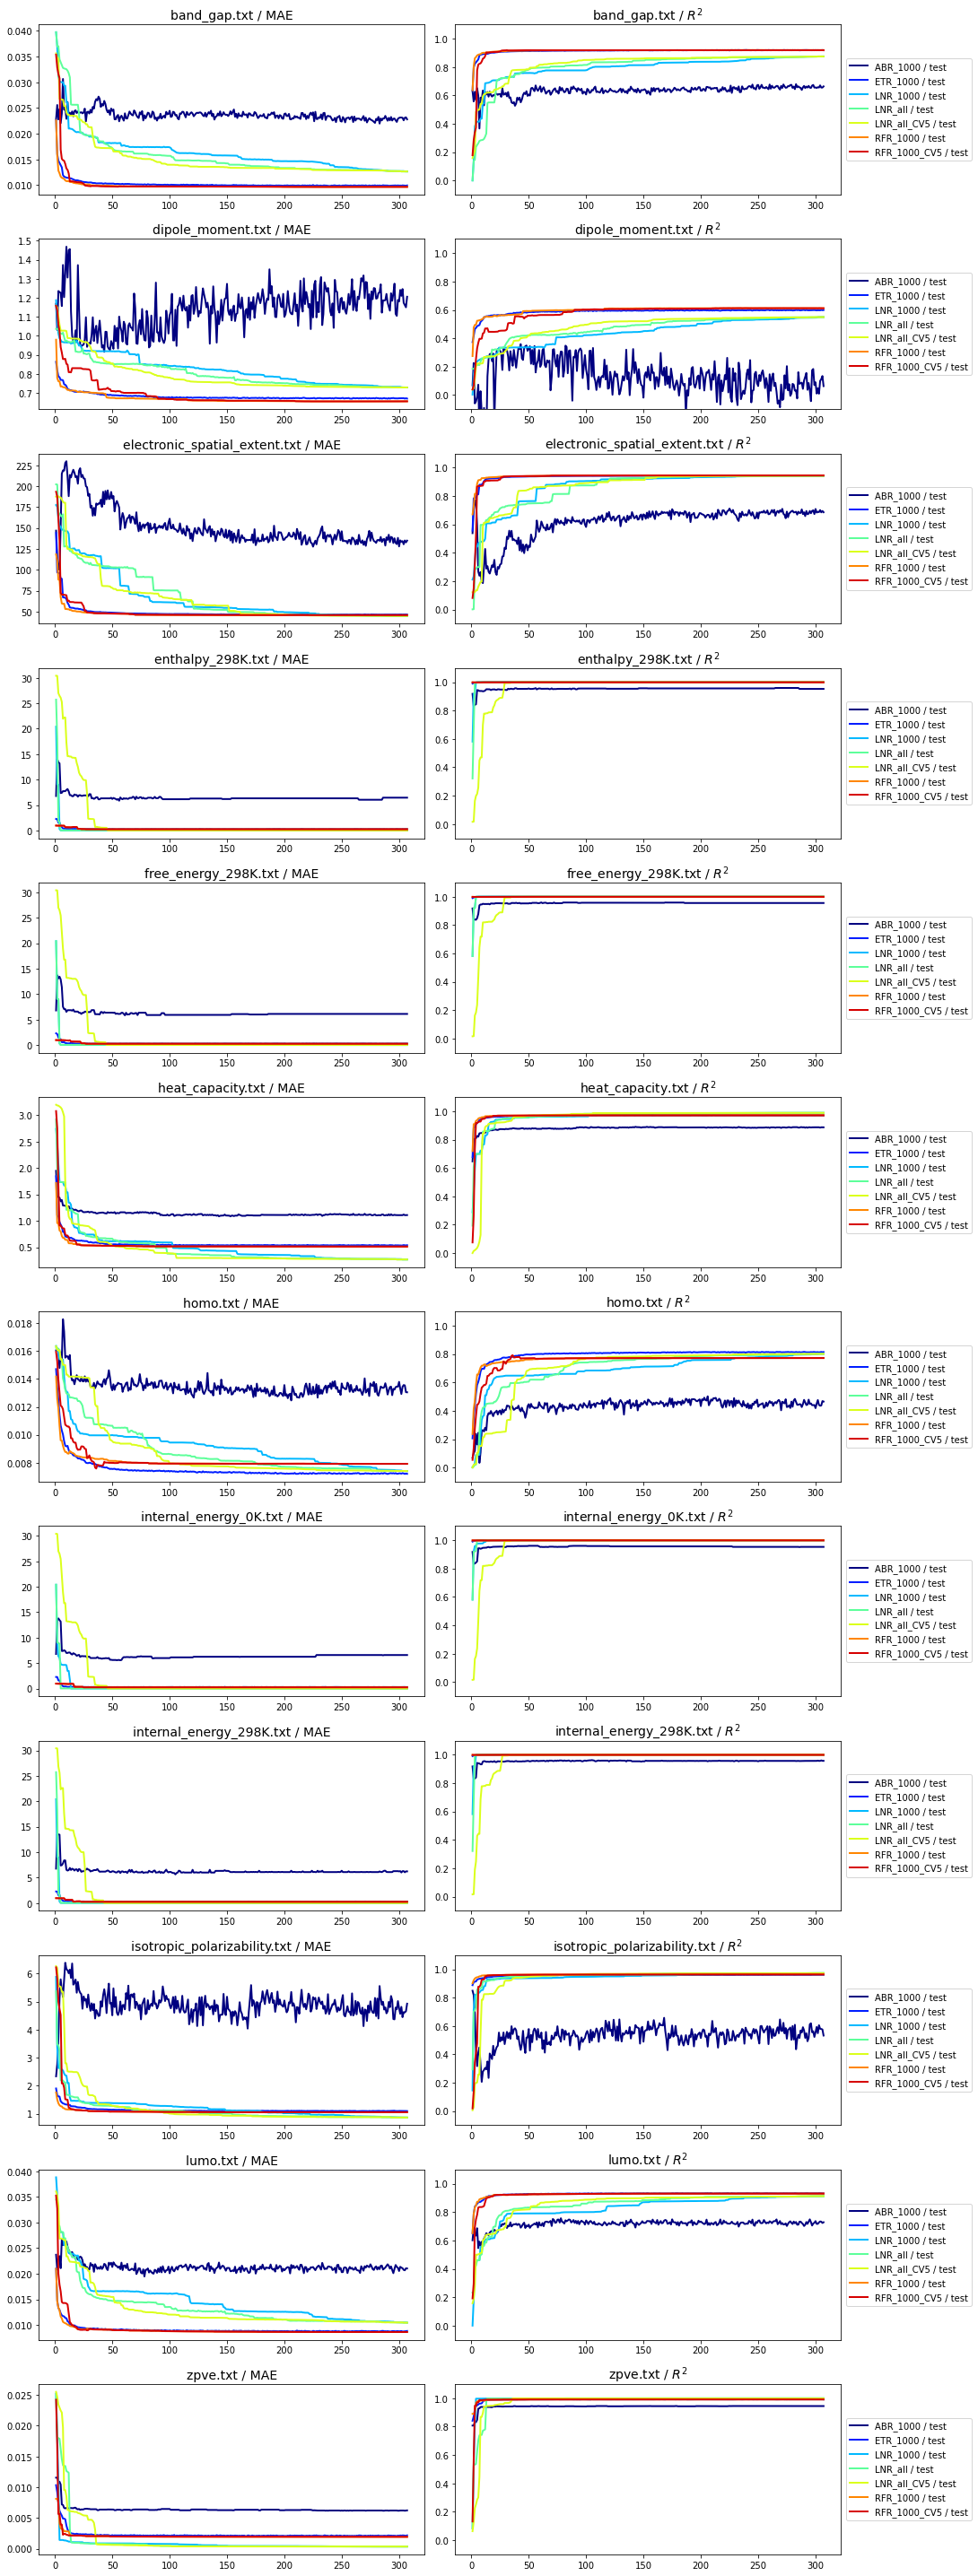

In [28]:
result = {}
for i in range(20):
    for j in range(20):
        output = read_RFE_test_result(i, j)
        if output is None: break
        loss, model, prop = output
        #if 'CV5' in model: continue
        if prop not in result.keys(): result[prop] = {}
        result[prop][model.replace('.pickle','').replace('r100t0.3_','')] = loss

cmap = plt.get_cmap('jet')
f, axs = plt.subplots(12, 2, figsize=(15, 40))
for i, (ax, (prop, output)) in enumerate(zip(axs, result.items())):
    ax[0].set_title(f'{prop} / MAE', fontsize=14)
    ax[1].set_title(f'{prop} / $R^2$', fontsize=14)
    ax[1].set_ylim([-0.1,1.1])
    for j, (model, loss) in enumerate(output.items()):
        color = cmap((j+1e-5)/(6.5+1e-4))
        x, train_mae, train_r2, test_mae, test_r2 = loss
#        ax[0].plot(x, train_mae, color=color[:3] + (0.5,), label=f'{model} / train')
        ax[0].plot(x, test_mae, color=color, lw=2, label=f'{model} / test')
#        ax[1].plot(x, train_r2, color=color[:3] + (0.5,), label=f'{model} / train')
        ax[1].plot(x, test_r2, color=color, lw=2, label=f'{model} / test')
    ax[1].legend(loc='center right', bbox_to_anchor=[1.35, 0.5])
plt.tight_layout()

In [110]:
loss

array([[1.00000000e+00, 2.00000000e+00, 3.00000000e+00, ...,
        3.05000000e+02, 3.06000000e+02, 3.07000000e+02],
       [2.39676444e-02, 1.62671163e-02, 5.38229916e-03, ...,
        1.80745368e-03, 1.80734900e-03, 1.80739878e-03],
       [1.58747704e-01, 5.84149761e-01, 9.53191446e-01, ...,
        9.93294330e-01, 9.93293829e-01, 9.93292894e-01],
       [2.42297625e-02, 1.66205818e-02, 5.64506271e-03, ...,
        1.93453567e-03, 1.93426084e-03, 1.93445334e-03],
       [1.31312890e-01, 5.59823267e-01, 9.47775272e-01, ...,
        9.91913186e-01, 9.91917223e-01, 9.91912626e-01]])

# Mutual information, $I(X;Y)$

In [43]:
from sklearn.feature_selection import mutual_info_regression, r_regression
import numpy as np
import tqdm
def calc_mir(feature):
    N = feature.shape[1]
    output = np.zeros((N,N), dtype=float)
    for i in tqdm.tqdm(range(N), total=N):
        mask = np.ones(N, dtype=bool)
        mask[i] = False
        mi = mutual_info_regression(feature[:,mask], feature[:,i])
        output[i, mask] = mi
    return output

def calc_pcc(feature):
    N = feature.shape[1]
    output = np.zeros((N,N), dtype=float)
    for i in tqdm.tqdm(range(N), total=N):
        mask = np.ones(N, dtype=bool)
        mask[i] = False
        mi = r_regression(feature[:,mask], feature[:,i])
        output[i, mask] = mi
    return output

In [13]:
feat_output = calc_mir(df_feat.values)
tgt_output = calc_mir(df_tgt.values)

100%|██████████| 12/12 [01:20<00:00,  6.72s/it]


In [15]:
import pickle
with open('mi_outputs.pickle','wb') as f:
    pickle.dump([feat_output, tgt_output], f)

In [39]:
mask = tgt_output > 1
ix, iy = np.where(mask)

for x, y in zip(ix, iy):
    print('{:3d} {:3d} / {:8.5f} {:8.5f} ({:8.5f})'.format(x, y, tgt_output[x,y], tgt_output[y,x], tgt_output[x,y] - tgt_output[y,x]))

  1   8 /  1.26043  1.26059 (-0.00016)
  1   9 /  1.25838  1.25880 (-0.00042)
  1  10 /  1.25838  1.25840 (-0.00002)
  1  11 /  1.26427  1.26468 (-0.00041)
  6   7 /  1.05519  1.05516 ( 0.00003)
  6   8 /  2.90888  2.90901 (-0.00013)
  6   9 /  2.91225  2.91231 (-0.00006)
  6  10 /  2.91225  2.91230 (-0.00004)
  6  11 /  2.90527  2.90535 (-0.00008)
  7   6 /  1.05516  1.05519 (-0.00003)
  8   1 /  1.26059  1.26043 ( 0.00016)
  8   6 /  2.90901  2.90888 ( 0.00013)
  8   9 /  8.37527  8.37527 (-0.00000)
  8  10 /  8.37522  8.37520 ( 0.00003)
  8  11 /  7.87950  7.87951 (-0.00001)
  9   1 /  1.25880  1.25838 ( 0.00042)
  9   6 /  2.91231  2.91225 ( 0.00006)
  9   8 /  8.37527  8.37527 ( 0.00000)
  9  10 / 10.54219 10.54217 ( 0.00001)
  9  11 /  7.53147  7.53147 ( 0.00000)
 10   1 /  1.25840  1.25838 ( 0.00002)
 10   6 /  2.91230  2.91225 ( 0.00004)
 10   8 /  8.37520  8.37522 (-0.00003)
 10   9 / 10.54217 10.54219 (-0.00001)
 10  11 /  7.53148  7.53149 (-0.00000)
 11   1 /  1.26468  1.264

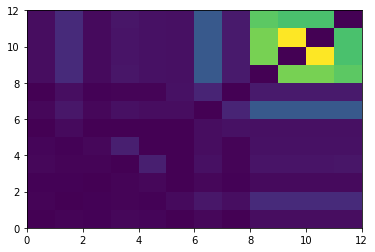

In [40]:
plt.pcolormesh(tgt_output)

In [42]:
mask = np.abs(feat_output - feat_output.T) > 0.01
mask = feat_output > 3
ix, iy = np.where(mask)

for x, y in zip(ix, iy):
    print('{:3d} {:3d} / {:8.5f} {:8.5f} ({:8.5f})'.format(x, y, feat_output[x,y], feat_output[y,x], feat_output[x,y] - feat_output[y,x]))

  8   9 /  3.93257  3.93361 (-0.00104)
  8  10 /  3.60063  3.59992 ( 0.00071)
  8  13 /  4.95895  4.95919 (-0.00024)
  8  40 /  6.49201  6.49527 (-0.00326)
  8  42 /  3.46116  3.46400 (-0.00284)
  8  43 /  4.27248  4.27554 (-0.00305)
  9   8 /  3.93361  3.93257 ( 0.00104)
  9  32 /  3.25662  3.25757 (-0.00095)
  9  40 /  3.00326  3.00516 (-0.00191)
  9  41 /  3.46275  3.46520 (-0.00245)
  9  42 /  4.36396  4.36202 ( 0.00194)
  9  43 /  3.67858  3.68197 (-0.00339)
  9  44 /  3.30268  3.30521 (-0.00253)
  9  54 /  3.09992  3.09790 ( 0.00202)
  9  55 /  3.26327  3.26089 ( 0.00237)
 10   8 /  3.59992  3.60063 (-0.00071)
 10  13 /  3.35061  3.35468 (-0.00407)
 10  40 /  3.60688  3.60945 (-0.00257)
 10  42 /  3.10714  3.11217 (-0.00503)
 11  12 /  6.31539  6.31799 (-0.00260)
 11  32 /  3.46084  3.45602 ( 0.00482)
 11  42 /  3.33888  3.33562 ( 0.00326)
 11  44 /  4.23169  4.23441 (-0.00272)
 11  53 /  4.28723  4.28914 (-0.00191)
 11  54 /  4.58475  4.58748 (-0.00273)
 11  55 /  3.46252  3.462

In [84]:
mutual_info_regression(df_tgt.values[:1000], df_tgt.values[:1000,10], random_state=2000)

array([0.31273412, 1.20277041, 0.39623151, 0.35358556, 0.38854235,
       0.79130653, 2.31475601, 0.59775862, 5.5627411 , 5.65063753,
       5.65063753, 5.46768352])

In [157]:
import numpy as np
from scipy.spatial.distance import cdist

x1 = np.array([[1, 2, 1, 1]])
x2 = np.array([[1, 1, 1, 1]])
xx1 = x1# - np.mean(x1)
xx2 = x2# - np.mean(x2)
r = np.mean(xx1*xx2)/np.sqrt(np.mean(np.square(xx1)) * np.mean(np.square(xx2)))
cdist(x1, x2, 'euclidean'), np.sqrt(np.sum(np.square(x1 - x2))), r

(array([[1.]]), 1.0, 0.944911182523068)